In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
data = pd.read_csv('traffic_volume_1hr.csv')
data.head()

,month,day,hr,total_volume
0,1,1,1,1165
1,1,1,2,1306
2,1,1,3,930
3,1,1,4,818
4,1,1,5,675


In [3]:
data.isnull().sum()

month           0
day             0
hr              0
total_volume    0
dtype: int64

In [4]:
print(data.shape)

(3624, 4)


In [5]:
data.describe()

,month,day,hr,total_volume
count,3624.000000,3624.000000,3624.000000,3624.000000
mean,3.013245,15.622517,12.500000,1955.531457
std,1.423683,8.752171,6.923142,1033.506698
min,1.000000,1.000000,1.000000,432.000000
25%,2.000000,8.000000,6.750000,921.000000
50%,3.000000,16.000000,12.500000,2005.000000
75%,4.000000,23.000000,18.250000,2854.000000
max,5.000000,31.000000,24.000000,4024.000000


In [6]:
df = data['total_volume']
dataset = df.values.astype('float32')
dataset = np.reshape(dataset, (len(dataset),1))

In [7]:
dataset.shape

(3624, 1)

### Data visualization

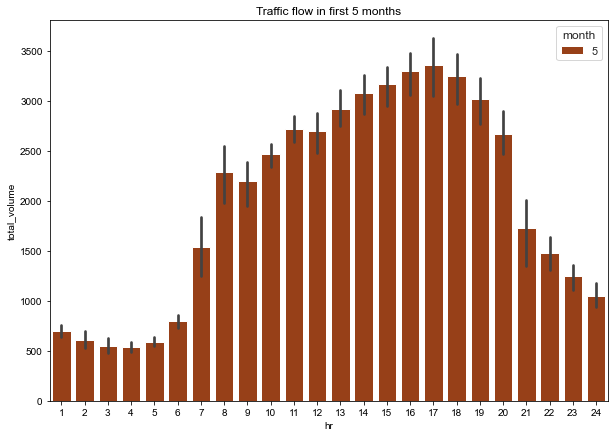

In [8]:
plot_data = data[(data.month == 5) & (data.day <= 7)]
fig, ax = plt.subplots(figsize=(10,7))
sns.set(style = "whitegrid")
ax = sns.barplot(x = "hr", hue = "month", y = "total_volume", data = plot_data,palette = sns.color_palette("Oranges_r") ).set(title = 'Traffic flow in first 5 months')

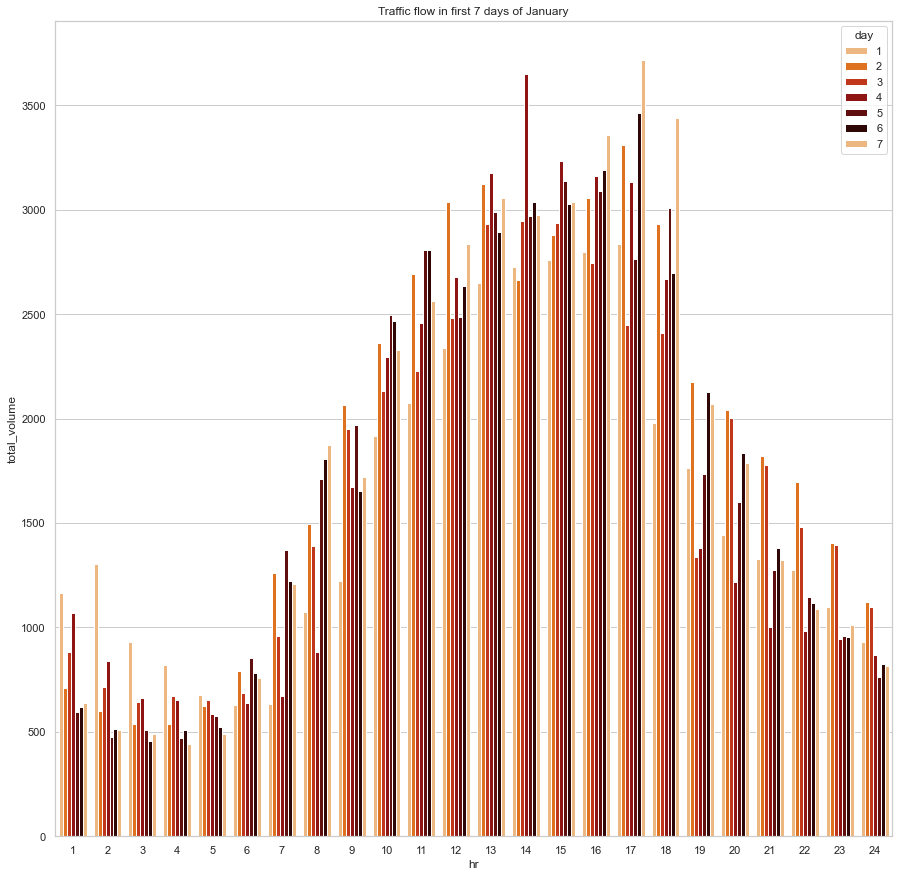

In [9]:
plot_data = data[(data.month == 1) & (data.day <= 7)]
fig, ax = plt.subplots(figsize=(15,15))
sns.set(style = "whitegrid")
ax = sns.barplot(x = "hr", hue = "day", y = "total_volume", data = plot_data, palette = sns.color_palette("gist_heat_r")).set(title = 'Traffic flow in first 7 days of January')

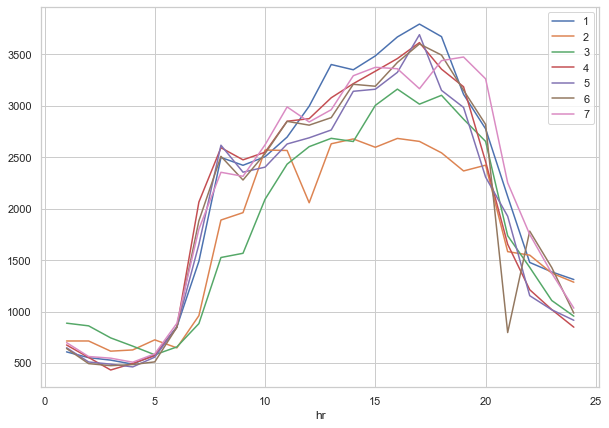

In [10]:
plot_data = data[(data.month == 5) & (data.day <= 7)]
fig, ax = plt.subplots(figsize=(10,7))
plot_data.set_index('hr', inplace=True)
pt = plot_data.groupby('day')['total_volume'].plot(legend=True)

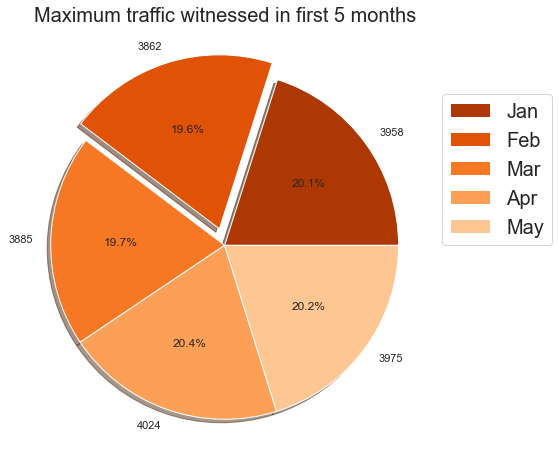

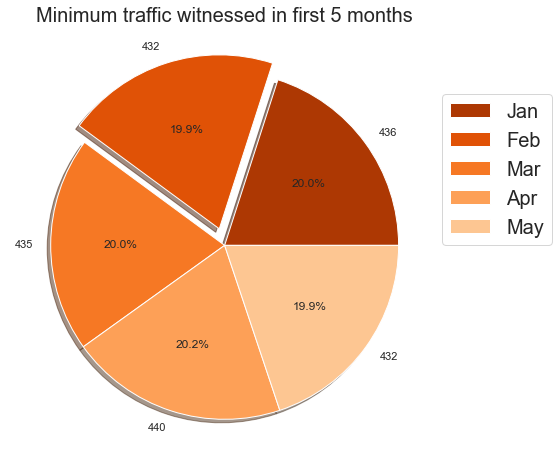

In [11]:
def pie(X1,s):
    fig, ax = plt.subplots(figsize=(8,8))
    e=[0,0.1,0,0,0]
    ax.set_title(s+' traffic witnessed in first 5 months',fontsize=20)
    ax.pie(X1, labels=X1,explode=e,shadow=True,colors=sns.color_palette("Oranges_r"), autopct='%.1f%%')
    plt.legend(labels=['Jan','Feb','Mar','Apr','May'],loc=(1,0.5),fontsize=20)

z = data.groupby(['month'])['total_volume']
list1=[]
list2=[]
for i in range(1,6):
    list1.append(max(z.get_group(i)))
    list2.append(min(z.get_group(i)))
    
pie(list1,"Maximum")
pie(list2,"Minimum")

### Deep learning model (LSTM)

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings("ignore")

### Normalize the dataset

In [13]:
scaler = MinMaxScaler(feature_range = (0,1))
dataset = scaler.fit_transform(dataset)

### Splitting dataset into train and test set

In [14]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train,test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

### Divide training and testing data into independent(X) and dependent(y)

In [15]:
def transform_dataset(dataset,look_back):
    dataX,dataY = [],[]
    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0])
    
    return np.array(dataX),np.array(dataY)

In [16]:
look_back = 24
trainX,trainY = transform_dataset(train,look_back)
testX,testY = transform_dataset(test,look_back)

In [17]:
trainX

array([[0.20406458, 0.2433185 , 0.13864142, ..., 0.2346882 , 0.18569043,
        0.13836303],
       [0.2433185 , 0.13864142, 0.10746103, ..., 0.18569043, 0.13836303,
        0.07795101],
       [0.13864142, 0.10746103, 0.06765034, ..., 0.13836303, 0.07795101,
        0.04732739],
       ...,
       [0.75974387, 0.7586303 , 0.8296214 , ..., 0.63001114, 0.6703786 ,
        0.74693763],
       [0.7586303 , 0.8296214 , 0.88390875, ..., 0.6703786 , 0.74693763,
        0.8346325 ],
       [0.8296214 , 0.88390875, 0.9323497 , ..., 0.74693763, 0.8346325 ,
        0.9334632 ]], dtype=float32)

In [18]:
trainY

array([0.07795101, 0.04732739, 0.02923163, ..., 0.8346325 , 0.9334632 ,
       0.9095212 ], dtype=float32)

In [19]:
print(trainX.shape)

(2511, 24)


In [20]:
print(trainY.shape)

(2511,)


In [21]:
print(testX.shape)

(1063, 24)


In [22]:
trainX=np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX=np.reshape(testX,(testX.shape[0],testX.shape[1],1))

In [23]:
print(trainX.shape)
print(testX.shape)

(2511, 24, 1)
(1063, 24, 1)


### LSTM model with metrics mean_squared_error

In [24]:
sgd = SGD(lr = 0.1)
model = Sequential()
model.add(LSTM(1,input_shape=(look_back,1)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = sgd)
model.fit(trainX,trainY,epochs = 10,batch_size = 1,verbose = 2)

Epoch 1/10
2511/2511 - 7s - loss: 0.0144
Epoch 2/10
2511/2511 - 6s - loss: 0.0090
Epoch 3/10
2511/2511 - 6s - loss: 0.0088
Epoch 4/10
2511/2511 - 7s - loss: 0.0087
Epoch 5/10
2511/2511 - 7s - loss: 0.0087
Epoch 6/10
2511/2511 - 7s - loss: 0.0087
Epoch 7/10
2511/2511 - 7s - loss: 0.0088
Epoch 8/10
2511/2511 - 7s - loss: 0.0086
Epoch 9/10
2511/2511 - 7s - loss: 0.0087
Epoch 10/10
2511/2511 - 7s - loss: 0.0087


### Predict traffic value on test data

In [25]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [26]:
trainPredict

array([[ 822.5017 ],
       [ 574.417  ],
       [ 510.38873],
       ...,
       [3070.3613 ],
       [3290.7075 ],
       [3536.162  ]], dtype=float32)

In [27]:
testPredict

array([[3385.784 ],
       [3331.64  ],
       [3306.6807],
       ...,
       [2869.2393],
       [1833.3677],
       [1314.4132]], dtype=float32)

In [28]:
train_score = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test score: %.2f RMSE' % (test_score))

Train score: 321.24 RMSE
Test score: 356.48 RMSE


### plot actual values vs predicted values

In [29]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [39]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

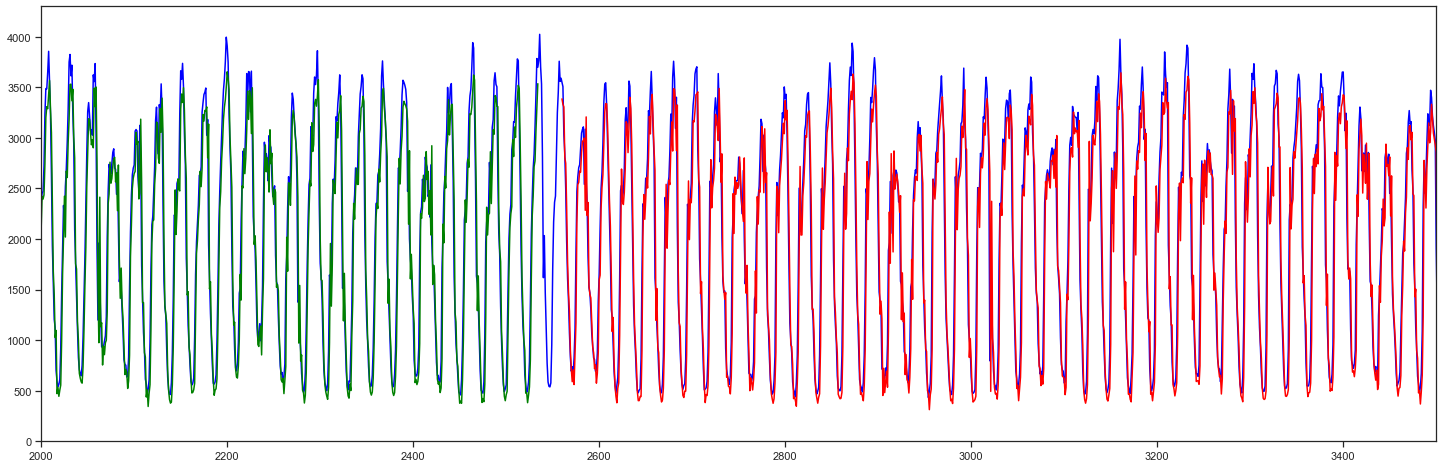

In [38]:
sns.set(style = 'ticks')
fig,ax = plt.subplots(figsize = (25,8))
plt.plot(scaler.inverse_transform(dataset), color = 'blue')
plt.plot(trainPredictPlot, color = 'green')
plt.plot(testPredictPlot, color = 'red')
plt.xlim(2000, 3500)
plt.ylim(0,4300)
plt.show()